In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

In [ ]:
from dul_2021.utils.hw4_utils import *

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
import copy

from scipy.stats import norm
from tqdm._tqdm_notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import torchdiffeq

# Question 1: 2D Data


Dataset 1


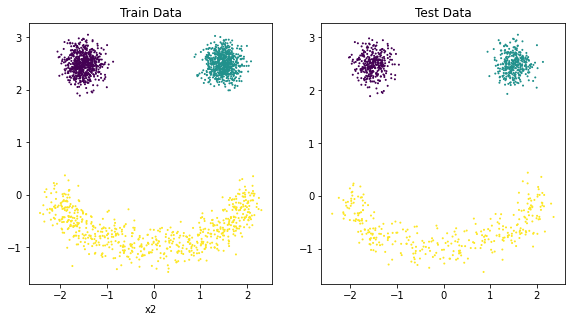

Dataset 2


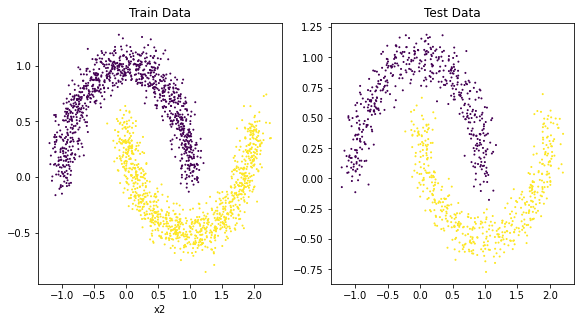

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial z} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [182]:
from torch.distributions import MultivariateNormal
import torch.utils.data as data


class CNF(nn.Module):
    def __init__(self, in_dim=2, hid_dim=32, width=3):
        super().__init__()
        self.in_dim = in_dim
        self.width = width
        self.param_dim = in_dim * width

        # 2 слоя
        # self.params_model = nn.Sequential(nn.Linear(1, hid_dim),
        #                                   nn.Tanh(),
        #                                   nn.Linear(hid_dim, 2 * in_dim * width + width))
        
        # 3 слоя
        self.params_model = nn.Sequential(nn.Linear(1, hid_dim),
                                          nn.Tanh(),
                                          nn.Linear(hid_dim, hid_dim),
                                          nn.Tanh(),
                                          nn.Linear(hid_dim, 2 * in_dim * width + width))
                

        self.bdist = MultivariateNormal(torch.zeros(in_dim).to(device),
                                        torch.eye(in_dim).to(device))

    #  dz(t) / dt = f(z(t), t)
    def f(self, t, z):
        out = self.params_model(t.unsqueeze(0)).squeeze()

        # v1
        # u = out[: self.param_dim].reshape(self.in_dim, self.width)
        # w = out[self.param_dim: 2 * self.param_dim].reshape(self.in_dim, self.width)
        # b = out[2 * self.param_dim:]
        # # shape: [bs, in_dim, width]
        # z = z.unsqueeze(2)
        # w = w.unsqueeze(0)
        # u = u.unsqueeze(0)
        # b = b.unsqueeze(0).unsqueeze(1)
        # h = (z * w + b).tanh()
        # return (h * u).mean(dim=2)

        # v2
        u = out[: self.param_dim].reshape(self.width, 1, self.in_dim)
        w = out[self.param_dim: 2 * self.param_dim].reshape(self.width, self.in_dim, 1)
        b = out[2 * self.param_dim:].reshape(self.width, 1, 1)
        zr = z.unsqueeze(0).repeat(self.width, 1, 1)
        h = (zr @ w + b).tanh()
        return (h @ u).mean(dim=0)


    # dlogp_z_dt = - tr[df / dz]          
    def dlogp_z_dt(self, f, z):
        bs = z.shape[0]
        res = torch.zeros(bs).to(device)
        for i in range(self.in_dim):
            res -= torch.autograd.grad(f[:, i].sum(), z,
                                       create_graph=True)[0][:, i]
        return res.reshape(bs, 1)


    def forward(self, t, input):
        z, _ = input
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = self.f(t, z)
            dlogp_z_dt = self.dlogp_z_dt(dz_dt, z)

        return (dz_dt, dlogp_z_dt)

    def flow(self, z1: torch.tensor, t0=0.0, t1=10.0):

        dlogp_z_dt1 = torch.zeros((z1.shape[0], 1)).to(device)

        zt, log_det_t = odeint(self, (z1, dlogp_z_dt1),
                                  torch.tensor([t1, t0]).to(device),
                                  atol=1e-5, rtol=1e-5, method='dopri5')
        
        return zt[-1], log_det_t[-1]


    def log_prob(self, x, t0=0.0, t1=10.0):
        z, log_det = self.flow(x, t0, t1)
        lop_p_z = self.bdist.log_prob(z).reshape(-1, 1)
        return lop_p_z - log_det


    def nll(self, batch, t0=0.0, t1=10.0,):
        return -self.log_prob(batch, t0, t1).mean()


    def test(self, test_dataloader, t0=0.0, t1=10.0):
        self.eval()
        total_loss = 0
        total_n = 0
        with torch.no_grad():
            for batch in test_dataloader:
                bs = batch.shape[0]
                batch = batch.to(device)
                loss = self.nll(batch, t0, t1)
                total_loss += bs * loss
                total_n += bs

        return total_loss / total_n


    def fit(self, train_data, test_data, t0=0.0, t1=10.0, num_epochs=20, lr=1e-3, batch_size=64):
        train_dataloader = data.DataLoader(torch.tensor(train_data, dtype=torch.float32),
                                           batch_size=batch_size,
                                           shuffle=True)
        test_dataloader = data.DataLoader(torch.tensor(test_data, dtype=torch.float32),
                                          batch_size=batch_size,
                                          shuffle=False)

        train_losses = []
        test_losses = []

        optim = opt.Adam(self.parameters(), lr=lr)
        test_losses.append(self.test(test_dataloader, t0, t1))

        for epoch in tqdm(range(num_epochs)):
            self.train()
            total_loss = 0
            total_n = 0
            for batch in train_dataloader:
                batch_size = batch.shape[0]
                batch = batch.to(device)
                loss = self.nll(batch, t0, t1)
                optim.zero_grad()
                loss.backward()
                optim.step()

                total_loss += batch_size * loss
                total_n += batch_size

                train_losses.append(total_loss.item() / total_n)
            test_loss_val = self.test(test_dataloader, t0, t1)
            test_losses.append(test_loss_val)
            print(f'Epoch {epoch + 1}:', test_loss_val.item())
        
        return train_losses, test_losses


    def latents(self, train_data):
        dataloader = data.DataLoader(torch.FloatTensor(train_data),
                                     batch_size=64, 
                                     shuffle=False)
        res = []
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                z = self.flow(batch)[0]
                z = z.cpu().numpy()
                res.append(z)

        return np.vstack(res)

In [183]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
    """

    model = CNF(width=5).to(device)
    train_losses, test_losses = model.fit(train_data, test_data, num_epochs=50)

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))

    # densities
    densities = np.exp(model.log_prob(mesh_xs).cpu().detach().numpy())

    # latents
    latents = model.latents(train_data)

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: 3.334012269973755
Epoch 2: 2.852696180343628
Epoch 3: 2.069258451461792
Epoch 4: 1.8382636308670044
Epoch 5: 1.8780094385147095
Epoch 6: 1.879269003868103
Epoch 7: 1.7898882627487183
Epoch 8: 1.8145097494125366
Epoch 9: 1.7901545763015747
Epoch 10: 1.7518121004104614
Epoch 11: 1.7882249355316162
Epoch 12: 1.76377534866333
Epoch 13: 1.8623653650283813
Epoch 14: 1.7604023218154907
Epoch 15: 1.813460111618042
Epoch 16: 1.739161729812622
Epoch 17: 1.7997243404388428
Epoch 18: 1.7517085075378418
Epoch 19: 1.7378650903701782
Epoch 20: 1.824272632598877
Epoch 21: 1.7621711492538452
Epoch 22: 1.8457231521606445
Epoch 23: 1.7281526327133179
Epoch 24: 1.7467994689941406
Epoch 25: 1.7953031063079834
Epoch 26: 1.7388921976089478
Epoch 27: 1.7328063249588013
Epoch 28: 1.7302093505859375
Epoch 29: 1.7339454889297485
Epoch 30: 1.8537101745605469
Epoch 31: 1.796604871749878
Epoch 32: 1.7154163122177124
Epoch 33: 1.7256920337677002
Epoch 34: 1.7150413990020752
Epoch 35: 1.7733455896377563
Epoc

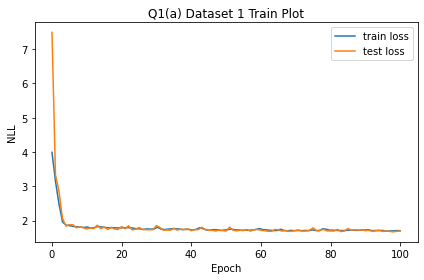

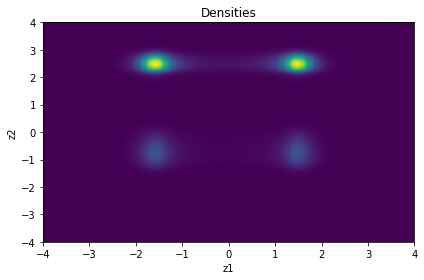

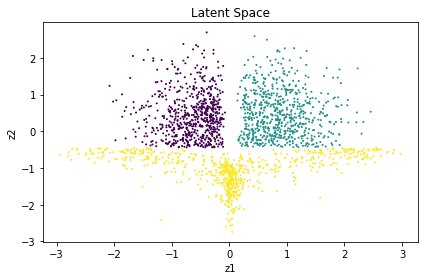

In [162]:
q1_save_results(1, 'a', q1) # v1

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: 3.130016326904297
Epoch 2: 2.405653715133667
Epoch 3: 1.965985894203186
Epoch 4: 1.9415088891983032
Epoch 5: 1.8803379535675049
Epoch 6: 1.7752283811569214
Epoch 7: 1.757822871208191
Epoch 8: 1.7333478927612305
Epoch 9: 1.7466192245483398
Epoch 10: 1.703537940979004
Epoch 11: 1.6230273246765137
Epoch 12: 1.740692138671875
Epoch 13: 1.5912847518920898
Epoch 14: 1.6097819805145264
Epoch 15: 1.6113088130950928
Epoch 16: 1.6151930093765259
Epoch 17: 1.5547890663146973
Epoch 18: 1.541136622428894
Epoch 19: 1.6329834461212158
Epoch 20: 1.5550076961517334
Epoch 21: 1.5096570253372192
Epoch 22: 1.516032099723816
Epoch 23: 1.5432971715927124
Epoch 24: 1.5896366834640503
Epoch 25: 1.5174298286437988
Epoch 26: 1.532934546470642
Epoch 27: 1.5356210470199585
Epoch 28: 1.4759066104888916
Epoch 29: 1.480283260345459
Epoch 30: 1.47157883644104
Epoch 31: 1.44760000705719
Epoch 32: 1.4610650539398193
Epoch 33: 1.4453305006027222
Epoch 34: 1.4277769327163696
Epoch 35: 1.5815114974975586
Epoch 36

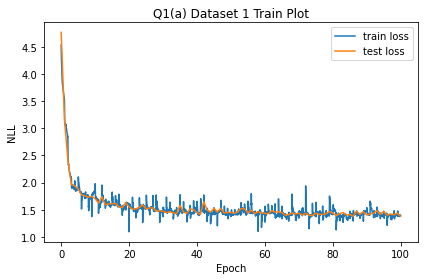

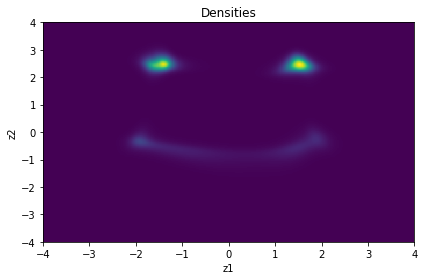

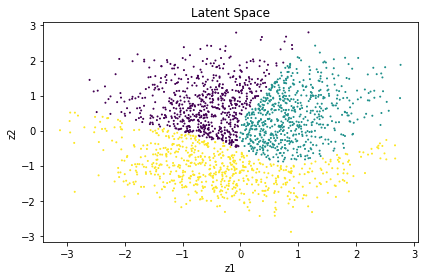

In [171]:
q1_save_results(1, 'a', q1) # v2

In [ ]:
# почему бродкастинг (v1) в f работает не так как repeat (v2)?

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 2.0665454864501953
Epoch 2: 2.0499625205993652
Epoch 3: 2.039594888687134
Epoch 4: 2.0371506214141846
Epoch 5: 2.0280344486236572
Epoch 6: 2.0376665592193604
Epoch 7: 2.0395638942718506
Epoch 8: 2.035308599472046
Epoch 9: 2.0330982208251953
Epoch 10: 2.033403158187866
Epoch 11: 2.027041435241699
Epoch 12: 2.0305793285369873
Epoch 13: 2.0256364345550537
Epoch 14: 2.0481436252593994
Epoch 15: 2.040238380432129
Epoch 16: 2.0344879627227783
Epoch 17: 2.043095350265503
Epoch 18: 2.0306177139282227
Epoch 19: 2.033649206161499
Epoch 20: 2.0307369232177734
Final Test Loss: 2.0307


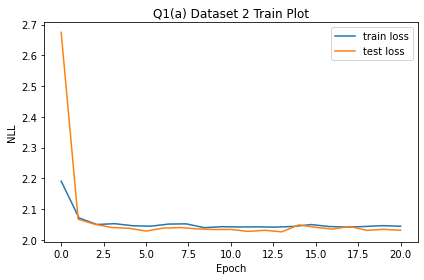

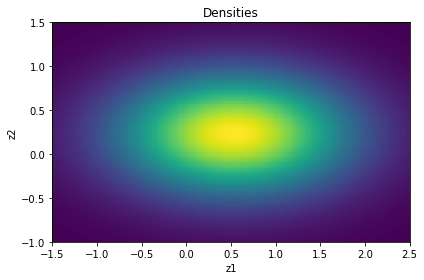

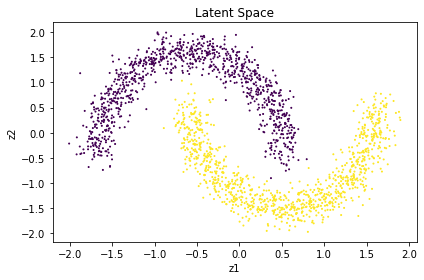

In [ ]:
q1_save_results(2, 'a', q1) # v1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: 1.9340418577194214
Epoch 2: 1.9400886297225952
Epoch 3: 1.9324945211410522
Epoch 4: 1.9261760711669922
Epoch 5: 1.9224146604537964
Epoch 6: 1.920110821723938
Epoch 7: 1.924759864807129
Epoch 8: 1.9255849123001099
Epoch 9: 1.9213905334472656
Epoch 10: 1.9218512773513794
Epoch 11: 1.93416428565979
Epoch 12: 1.9233916997909546
Epoch 13: 1.9244911670684814
Epoch 14: 1.9201267957687378
Epoch 15: 1.9215630292892456
Epoch 16: 1.910605788230896
Epoch 17: 1.8959161043167114
Epoch 18: 1.8764652013778687
Epoch 19: 1.839911937713623
Epoch 20: 1.8270728588104248
Epoch 21: 1.7707529067993164
Epoch 22: 1.668042778968811
Epoch 23: 1.5756169557571411
Epoch 24: 1.536964774131775
Epoch 25: 1.516079068183899
Epoch 26: 1.5320792198181152
Epoch 27: 1.521711826324463
Epoch 28: 1.5390125513076782
Epoch 29: 1.4894096851348877
Epoch 30: 1.4633790254592896
Epoch 31: 1.4364756345748901
Epoch 32: 1.4378242492675781
Epoch 33: 1.4177989959716797
Epoch 34: 1.4371328353881836
Epoch 35: 1.4064784049987793
Epoc

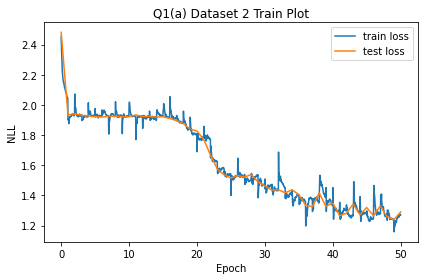

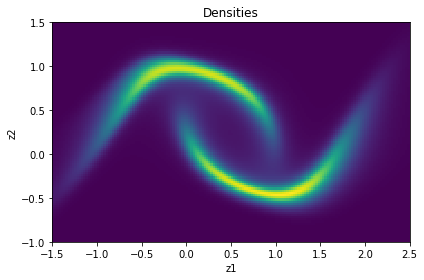

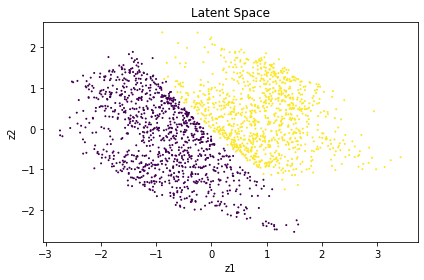

In [174]:
q1_save_results(2, 'a', q1) # v2

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
 D = q2_sample_data()
 D[0].shape, D[1].shape

((6000, 10), (600, 10))

In [179]:
class H_CNF(nn.Module):
    def __init__(self, in_dim=10, hid_dim=32, width=3):
        super().__init__()
        self.in_dim = in_dim
        self.width = width
        self.param_dim = in_dim * width

        # 2 слоя
        # self.params_model = nn.Sequential(nn.Linear(1, hid_dim),
        #                                   nn.Tanh(),
        #                                   nn.Linear(hid_dim, 2 * in_dim * width + width))
        
        # 3 слоя
        self.params_model = nn.Sequential(nn.Linear(1, hid_dim),
                                          nn.Tanh(),
                                          nn.Linear(hid_dim, hid_dim),
                                          nn.Tanh(),
                                          nn.Linear(hid_dim, 2 * in_dim * width + width))
                

        self.bdist = MultivariateNormal(torch.zeros(in_dim).to(device),
                                        torch.eye(in_dim).to(device))

    #  dz(t) / dt = f(z(t), t)
    def f(self, t, z):
        out = self.params_model(t.unsqueeze(0)).squeeze()

        # v1
        # u = out[: self.param_dim].reshape(self.in_dim, self.width)
        # w = out[self.param_dim: 2 * self.param_dim].reshape(self.in_dim, self.width)
        # b = out[2 * self.param_dim:]
        # # shape: [bs, in_dim, width]
        # z = z.unsqueeze(2)
        # w = w.unsqueeze(0)
        # u = u.unsqueeze(0)
        # b = b.unsqueeze(0).unsqueeze(1)
        # h = (z * w + b).tanh()
        # return (h * u).mean(dim=2)

        # v2
        u = out[: self.param_dim].reshape(self.width, 1, self.in_dim)
        w = out[self.param_dim: 2 * self.param_dim].reshape(self.width, self.in_dim, 1)
        b = out[2 * self.param_dim:].reshape(self.width, 1, 1)

        zr = z.unsqueeze(0).repeat(self.width, 1, 1)
        h = (zr @ w + b).tanh()
        return (h @ u).mean(dim=0)


    # dlogp_z_dt = - tr[df / dz]          
    def dlogp_z_dt(self, f, z):
        bs = z.shape[0]
        v = torch.randint(0, 2, (z.shape[1], 1)).to(device) * 2 - 1
        v = v.float()
        res = torch.autograd.grad((f @ v).sum(), z,
                                  create_graph=True)[0]
        res = -res @ v
        return res.reshape(bs, 1)


    def forward(self, t, input):
        z, _ = input
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = self.f(t, z)
            dlogp_z_dt = self.dlogp_z_dt(dz_dt, z)
        return (dz_dt, dlogp_z_dt)


    def flow(self, z1: torch.tensor, t0=0.0, t1=10.0):

        dlogp_z_dt1 = torch.zeros((z1.shape[0], 1)).to(device)
        zt, log_det_t = odeint(self, (z1, dlogp_z_dt1),
                                  torch.tensor([t1, t0]).to(device),
                                  atol=1e-5, rtol=1e-5, method='dopri5')
        return zt[-1], log_det_t[-1]


    def log_prob(self, x, t0=0.0, t1=10.0):
        z, log_det = self.flow(x, t0, t1)
        lop_p_z = self.bdist.log_prob(z).reshape(-1, 1)
        return lop_p_z - log_det


    def nll(self, batch, t0=0.0, t1=10.0,):
        return -self.log_prob(batch, t0, t1).mean()


    def test(self, test_dataloader, t0=0.0, t1=10.0):
        self.eval()
        total_loss = 0
        total_n = 0
        with torch.no_grad():
            for batch in test_dataloader:
                bs = batch.shape[0]
                batch = batch.to(device)
                loss = self.nll(batch, t0, t1)
                total_loss += bs * loss
                total_n += bs

        return total_loss / total_n


    def fit(self, train_data, test_data, t0=0.0, t1=10.0, num_epochs=20, lr=1e-3, batch_size=64):
        train_dataloader = data.DataLoader(torch.tensor(train_data, dtype=torch.float32),
                                           batch_size=batch_size,
                                           shuffle=True)
        test_dataloader = data.DataLoader(torch.tensor(test_data, dtype=torch.float32),
                                          batch_size=batch_size,
                                          shuffle=False)

        train_losses = []
        test_losses = []

        optim = opt.Adam(self.parameters(), lr=lr)
        test_losses.append(self.test(test_dataloader, t0, t1))

        for epoch in tqdm(range(num_epochs)):
            self.train()
            total_loss = 0
            total_n = 0
            for batch in train_dataloader:
                batch_size = batch.shape[0]
                batch = batch.to(device)
                loss = self.nll(batch, t0, t1)
                optim.zero_grad()
                loss.backward()
                optim.step()

                total_loss += batch_size * loss
                total_n += batch_size

                train_losses.append(total_loss.item() / total_n)
            test_loss_val = self.test(test_dataloader, t0, t1)
            test_losses.append(test_loss_val)
            print(f'Epoch {epoch + 1}:', test_loss_val.item())
        
        return train_losses, test_losses


    def latents(self, train_data):
        dataloader = data.DataLoader(torch.FloatTensor(train_data),
                                     batch_size=64, 
                                     shuffle=False)
        res = []
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                z = self.flow(batch)[0]
                z = z.cpu().numpy()
                res.append(z)

        return np.vstack(res)

In [180]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """
  
    model = H_CNF().to(device)
    train_losses, test_losses = model.fit(train_data, test_data, num_epochs=50)

    return train_losses, test_losses


### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 13.442272186279297
Epoch 2: 13.387731552124023
Epoch 3: 13.358789443969727
Epoch 4: 13.362401962280273
Epoch 5: 13.364209175109863
Epoch 6: 13.335411071777344
Epoch 7: 13.346343040466309
Epoch 8: 13.359183311462402
Epoch 9: 13.358756065368652
Epoch 10: 13.336216926574707
Epoch 11: 13.322527885437012
Epoch 12: 13.319171905517578
Epoch 13: 13.329097747802734
Epoch 14: 13.32447624206543
Epoch 15: 13.326456069946289
Epoch 16: 13.295547485351562
Epoch 17: 13.305832862854004
Epoch 18: 13.307564735412598
Epoch 19: 13.3381986618042
Epoch 20: 13.318883895874023
Final Test Loss: 13.3189


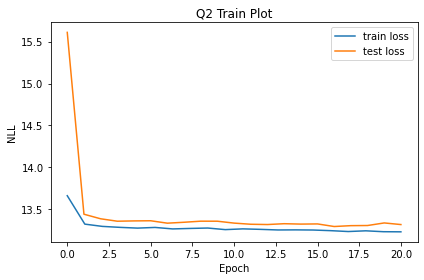

In [144]:
q2_save_results(q2)

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b3(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  """ YOUR CODE HERE """


### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(b3)